# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [6]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [7]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [8]:
def dist_vs_idx_dist(com_arr):
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :] - com_arr[np.newaxis, :, :], axis=2)
    avg_dist_arr = np.zeros((sep_mat.shape[0]))
    avg_dist_sem_arr = np.zeros((sep_mat.shape[0]))
    for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr[i] = diag.mean()
        avg_dist_sem_arr[i] = stats.sem(diag)
    return avg_dist_arr, avg_dist_sem_arr
    

# Figure 2 (Free chain collapse)

__Questions__:
1. How should I initialize the polymer?
    - Completely straight? (I can equilibrate afterwards but for how long?)
    - Equilibrate at some fraction of its total length?
    - Full equilibration?
2. What different lengths do I want to use?

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


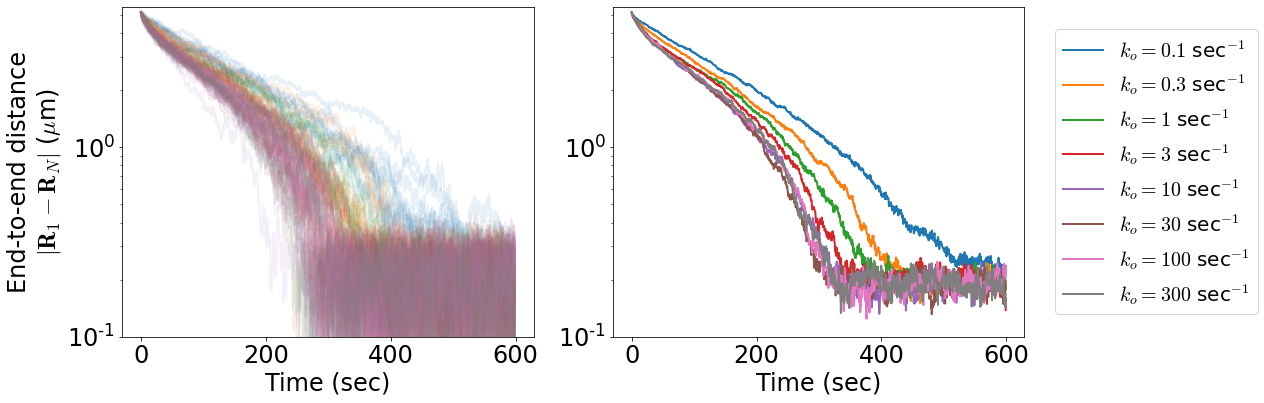

In [9]:
data_path = ceph_path / "22_aLc800_sticky_runs/22-04-08_aLc1_scan8.12_line800_sticky55nm_ko.1-300/simulations/"
colors = list(mcolors.TABLEAU_COLORS.keys())
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    
    ss_ind = 1
    end_ind = 1200
    start_bead = 0
    end_bead = None

    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/*.h5')]
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
           
            ee_dist = aa.get_end_end_distance(com_arr)
            _ = axarr1[0].plot(time_arr, ee_dist, color=colors[i], alpha=.1)
            avg_ee_arrs += [ee_dist.tolist()]
        
        avg_ee_arrs = np.array(avg_ee_arrs)
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr, avg_ee_list[-1], color=colors[i], label=f"$k_o = {label}$ sec$^{{-1}}$")
    
    _ = axarr1[0].set_ylim(0.1)
    
    _ = axarr1[0].set_ylabel('End-to-end distance\n' + r'$|{\bf R}_1 - {\bf R}_N|$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

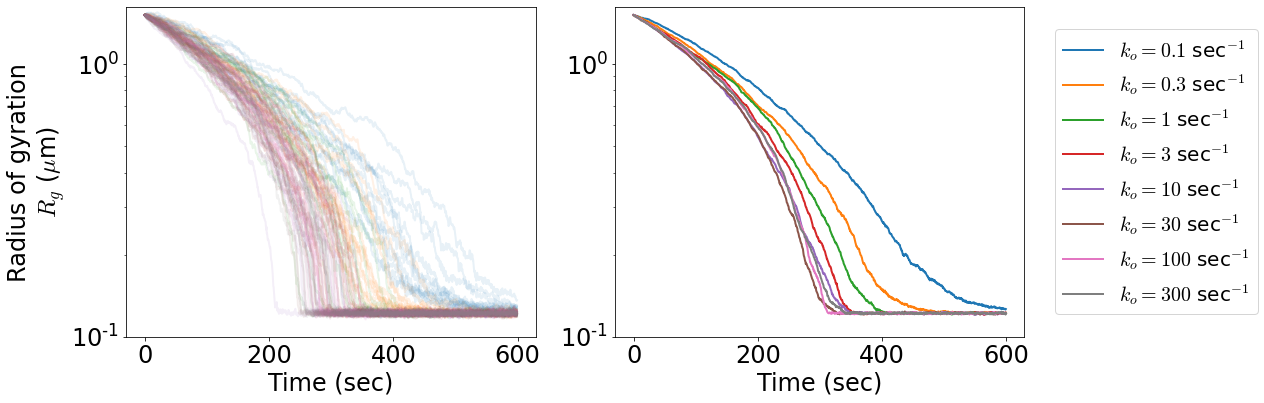

In [19]:
data_path = ceph_path / "22_aLc800_sticky_runs/22-04-08_aLc1_scan8.12_line800_sticky55nm_ko.1-300/simulations/"
colors = list(mcolors.TABLEAU_COLORS.keys())
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    
    ss_ind = 1
    end_ind = 1200
    start_bead = 0
    end_bead = None


    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/*.h5')]
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
           
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        
        avg_ee_arrs = np.array(avg_ee_arrs)
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr, avg_ee_list[-1], color=colors[i], label=f"$k_o = {label}$ sec$^{{-1}}$")
        # _ = axarr1[1].plot(time_arr, avg_ee_list[-1][0]*np.exp(-float(label)*time_arr/np.sqrt(float(n_beads))), color=colors[i])
    
    _ = axarr1[0].set_ylim(0.1)
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

number of estimated clusters : 1
number of thresholded clusters : 1
Volume of condensate: 16129341.070924753 nm$^3$
Volume per bead: 20288.479334496544 nm$^3$
number of estimated clusters : 1
number of thresholded clusters : 1
Volume of condensate: 15991382.646481914 nm$^3$
Volume per bead: 20293.63280010395 nm$^3$
number of estimated clusters : 1
number of thresholded clusters : 1
Volume of condensate: 16810186.452499054 nm$^3$
Volume per bead: 21171.51946158571 nm$^3$
number of estimated clusters : 1
number of thresholded clusters : 1
Volume of condensate: 16225204.910015587 nm$^3$
Volume per bead: 20306.889749706617 nm$^3$


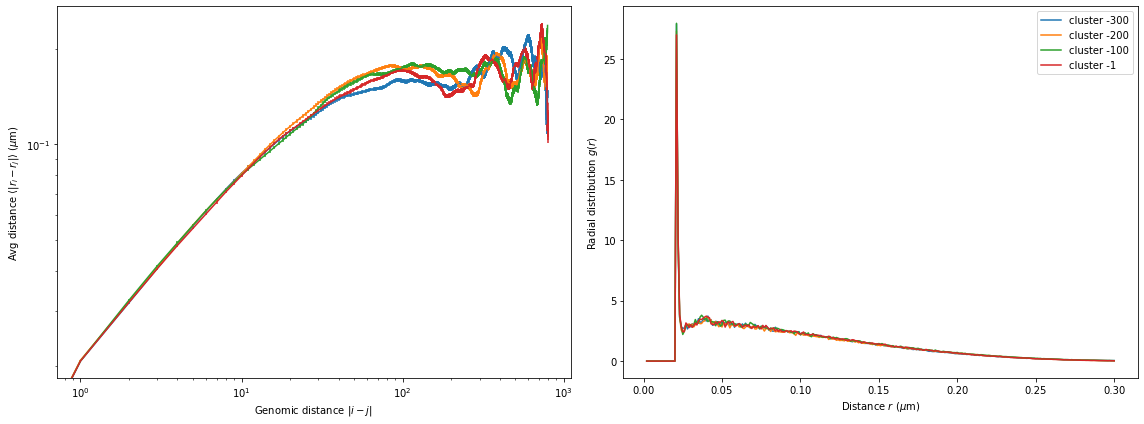

In [5]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-08_aLc1_scan8.12_line800_sticky55nm_ko.1-300/simulations/kod3/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
t = -1 # Snapshot time to use

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

warnings.filterwarnings('ignore')
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    for t in [-300, -200, -100,-1]:
        com_arr = .5 * (sy_dat[:, 2:5, t] + sy_dat[:, 5:8, t])

        clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
            com_arr)

        for i, cli in enumerate(cluster_label_inds):
            clust_ind_com = com_arr[cli]
            hull = ConvexHull(clust_ind_com)
            print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
            print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")

            avg_dist_arr, avg_dist_sem_arr = dist_vs_idx_dist(clust_ind_com) 
            dist_mat = np.linalg.norm((clust_ind_com[:, np.newaxis, :] -
                                clust_ind_com[np.newaxis, :, :]),
                                axis=2)
            # hist_max =1.1 * np.max(dist_mat)
            hist_max = .3
            rad_distr_func, rad_bin_edges = ca.rad_distr_func_at_t(dist_mat, nbins=int(hist_max/.001), hist_max=hist_max)
        
            _ = axarr[0].errorbar(np.arange(len(avg_dist_arr)), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'cluster {t}')
            _ = axarr[1].plot(rad_bin_edges[2:], rad_distr_func[1:]*hull.volume, label=f'cluster {t}')


_ = axarr[0].set_yscale("log")
_ = axarr[0].set_xscale("log")
# _ = axarr[1].set_yscale("log")


_ = axarr[0].set_xlabel(r"Genomic distance $|i - j|$ ")
_ = axarr[0].set_ylabel(r"Avg distance $\langle |r_i - r_j|\rangle$ ($\mu$m)")
_ = axarr[1].set_xlabel(r"Distance $r$ ($\mu$m)")
_ = axarr[1].set_ylabel(r"Radial distribution $g(r)$")

# _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr[1].legend()
fig.tight_layout()
# cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



# Figure 3 (Long chain dynamics)

## Free polymer

## Confined polymer

# Figure 4 (Pinned short chain parameter scans)

# Figure 5 (Cluster growth dynamics phase diagrams)

# Figure 6 (Minimal model for pinned growth dynamics)

# Figure 7 (Long copolymer analysis)